In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss,confusion_matrix,classification_report,roc_curve,auc
from sklearn.metrics import precision_recall_curve
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from sklearn.metrics import f1_score
from keras.models import Model
from keras.layers import Input, Embedding, Dense, Conv2D, MaxPool2D
from keras.layers import Reshape, Flatten, Concatenate, Dropout, SpatialDropout1D
from keras.preprocessing import text, sequence
from keras.callbacks import Callback

Using TensorFlow backend.


In [2]:
#load the data
train = pd.read_csv("train.csv")
train.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


### defining features related to the CNN model

In [3]:
max_features = 40000
maxlen = 70
embed_size = 300
threshold = 0.35
filter_sizes = [1,2,3]
num_filters = 42

### Tokenization

In [4]:
train_, test_ = train_test_split(train,random_state=42, test_size=0.1, shuffle=True)
train = train_.sample(frac = 0.05)
test = test_.sample(frac = 0.05)

X_train = train["question_text"].fillna("fillna").values
y_train = train["target"].values
X_test = test["question_text"].fillna("fillna").values

max_features = 40000
maxlen = 50
embed_size = 300

tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train) + list(X_test))
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
x_train = sequence.pad_sequences(X_train, maxlen=maxlen)
x_test = sequence.pad_sequences(X_test, maxlen=maxlen)

### Getting word Embeddings from Glove

In [5]:
EMBEDDING_FILE = 'glove.840B.300d.txt'
def get_coefs(word,*arr): 
    return word, np.asarray(arr, dtype='float32')

embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))

def get_coefs(word, *arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

### Building the Model

In [7]:
filter_sizes = [1,2,3]
num_filters = 40
from keras.layers import Conv1D, MaxPool1D, BatchNormalization

def buildCNN():    
    inp = Input(shape=(maxlen, ))
    x = Embedding(max_features, 300, weights=[embedding_matrix])(inp)
    x = SpatialDropout1D(0.4)(x)
    
    conv1 = Conv1D(num_filters, kernel_size=(filter_sizes[0]),
                                 kernel_initializer='he_normal', activation='elu')(x)
    conv2 = Conv1D(num_filters, kernel_size=(filter_sizes[1]),
                                 kernel_initializer='he_normal', activation='elu')(x)
    conv3 = Conv1D(num_filters, kernel_size=(filter_sizes[2]), 
                                 kernel_initializer='he_normal', activation='elu')(x)
    
    maxpool1 = MaxPool1D(pool_size=(maxlen - filter_sizes[0] + 1))(conv1)
    maxpool2 = MaxPool1D(pool_size=(maxlen - filter_sizes[1] + 1))(conv2)
    maxpool3 = MaxPool1D(pool_size=(maxlen - filter_sizes[2] + 1))(conv3)
        
    z = Concatenate(axis=1)([maxpool0, maxpool1, maxpool2])   
    z = Flatten()(z)
    z = BatchNormalization()(z)
        
    output = Dense(1, activation="sigmoid")(z)
    model = Model(inputs=inp, outputs=output)
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

    return model

model = buildCNN()

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [9]:
print model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 50, 300)      12000000    input_2[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_2 (SpatialDro (None, 50, 300)      0           embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 50, 40)       12040       spatial_dropout1d_2[0][0]        
__________________________________________________________________________________________________
conv1d_5 (

In [10]:
X_tra, X_val, y_tra, y_val = train_test_split(x_train, y_train, train_size=0.80,random_state=42)

In [16]:
epoch_runs = model.fit(X_tra, y_tra, batch_size=1024, epochs=10,
                 validation_data=(X_val, y_val),verbose=True)

Train on 55836 samples, validate on 2939 samples
Epoch 1/10
55836/55836 [==============================] - 68s 1ms/step - loss: 0.1283 - acc: 0.9571 - val_loss: 0.1305 - val_acc: 0.9500
Epoch 2/10
55836/55836 [==============================] - 64s 1ms/step - loss: 0.1079 - acc: 0.9622 - val_loss: 0.1245 - val_acc: 0.9520
Epoch 3/10
55836/55836 [==============================] - 60s 1ms/step - loss: 0.0949 - acc: 0.9658 - val_loss: 0.1250 - val_acc: 0.9544
Epoch 4/10
55836/55836 [==============================] - 59s 1ms/step - loss: 0.0854 - acc: 0.9693 - val_loss: 0.1234 - val_acc: 0.9537
Epoch 5/10
55836/55836 [==============================] - 66s 1ms/step - loss: 0.0738 - acc: 0.9739 - val_loss: 0.1287 - val_acc: 0.9520
Epoch 6/10
55836/55836 [==============================] - 70s 1ms/step - loss: 0.0659 - acc: 0.9763 - val_loss: 0.1271 - val_acc: 0.9537
Epoch 7/10
55836/55836 [==============================] - 61s 1ms/step - loss: 0.0593 - acc: 0.9785 - val_loss: 0.1293 - val_acc:

In [17]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

In [21]:
threshold = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

predictions = model.predict(X_val)
f1_scores = []

for t in threshold:
    y_pred = (predictions > t).astype(int)
    print 'threshold: ', t
    print 'accuracy', accuracy_score(y_val, y_pred)
    print 'classification report:'
    print classification_report(y_val, y_pred)
    print '======================'
    f1_scores.append(f1_score(y_val, y_pred))

threshold:  0.0001
accuracy 0.20347056822048315
classification report:
              precision    recall  f1-score   support

           0       1.00      0.15      0.26      2763
           1       0.07      1.00      0.13       176

   micro avg       0.20      0.20      0.20      2939
   macro avg       0.53      0.58      0.20      2939
weighted avg       0.94      0.20      0.26      2939

threshold:  0.001
accuracy 0.5767267778155836
classification report:
              precision    recall  f1-score   support

           0       1.00      0.55      0.71      2763
           1       0.12      0.98      0.22       176

   micro avg       0.58      0.58      0.58      2939
   macro avg       0.56      0.77      0.46      2939
weighted avg       0.95      0.58      0.68      2939

threshold:  0.01
accuracy 0.8451854372235454
classification report:
              precision    recall  f1-score   support

           0       0.99      0.84      0.91      2763
           1       0.27      

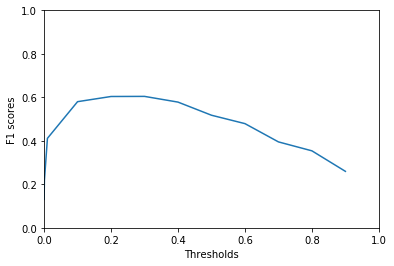

In [22]:
import matplotlib.pyplot as plt
plt.plot(threshold, f1_scores)
plt.xlim(0,1)
plt.ylim(0,1)
plt.ylabel('F1 scores')
plt.xlabel('Thresholds')
plt.show()